In [2]:
!pip install mlxtend

In [56]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import platform
from matplotlib import font_manager, rc

# '-' 기호 보이게 하기
matplotlib.rcParams['axes.unicode_minus'] = False

# 운영 체제마다 한글이 보이게 하는 설정
# 윈도우
if platform.system() == 'Windows':
    path = "c:\Windows\Fonts\malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
# 맥
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
# 리눅스
elif platform.system() == 'Linux':
    plt.rc('font', family='NanumBarunGothic')

# 20대 마트/슈퍼/편의점 이용 데이터 연관분석

## 1. 데이터파일 준비

In [59]:
df_demo = pd.read_csv('data/LPOINT_BIG_COMP_01_DEMO.csv') # 고객정보
df_pdde = pd.read_csv('data/LPOINT_BIG_COMP_02_PDDE.csv', parse_dates = [6]) # 구매정보
df_copu = pd.read_csv('data/LPOINT_BIG_COMP_03_COP_U.csv', parse_dates = [5, 6]) # 유통사 이용 정보 (B01 ~ E00)
df_pd = pd.read_csv('data/LPOINT_BIG_COMP_04_PD_CLAC.csv') # 상품 정보

df_pdde['weekday'] = df_pdde['de_dt'].dt.weekday

DF = pd.merge(df_pdde, df_demo, on = 'cust')
DF = pd.merge(DF, df_pd, on = 'pd_c')
DF = DF.loc[(DF['ages'] == '20대')&(DF['cop_c'].apply(lambda x: x in ['A02', 'A03', 'A04']))]
print(DF.shape)
DF.head()

C:\Users\Eugene\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(196262, 17)


,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,weekday,ma_fem_dv,ages,zon_hlv,pd_nm,clac_hlv_nm,clac_mcls_nm
654,M496844384,A02191496496,1,A02,A020053,PD0290,2021-05-08,17,39000.0,1,5,여성,20대,Z17,남성티셔츠,남성의류,남성의류상의
2574,M748140584,A02262444001,1,A02,A020080,PD0290,2021-01-08,17,20000.0,2,4,남성,20대,Z11,남성티셔츠,남성의류,남성의류상의
2575,M748140584,A02262444001,1,A02,A020080,PD0290,2021-01-08,17,9000.0,9,4,남성,20대,Z11,남성티셔츠,남성의류,남성의류상의
2576,M748140584,A02262444001,1,A02,A020080,PD0290,2021-01-08,17,900.0,9,4,남성,20대,Z11,남성티셔츠,남성의류,남성의류상의
3166,M395590139,A02064243742,1,A02,A020012,PD0290,2021-02-01,11,600.0,6,0,여성,20대,Z17,남성티셔츠,남성의류,남성의류상의


# 1. 식품을 구매한 장바구니 한정
## 01. 상품만 아이템으로 넣기
### a) 중분류

In [97]:
# 중분류
foods = ['건강식품', '건해산물', '과일', '과자', '냉동식품', '냉장식품', '대용식', '병통조림', '수산물', '주류', '채소'
         , '축산물', '커피/차', '양곡', '유제품', '음료', '조리식품', '조미료']
df_food = DF.loc[DF['clac_hlv_nm'].apply(lambda x: x in foods)]
df = df_food[['rct_no', 'clac_mcls_nm', 'buy_ct']]

### 탐색적 데이터 분석

In [98]:
df = df.groupby(['rct_no', 'clac_mcls_nm'])['buy_ct'].sum()

In [99]:
df

rct_no        clac_mcls_nm
A02000091219  수산물통조림          2
A02000284827  비스킷류            1
              전통과자류           1
              차음료             1
A02000397555  국산과일            1
                             ..
E03012315704  냉장간편식           2
              비스킷류            4
              우유              2
              커피음료            3
              탄산음료            9
Name: buy_ct, Length: 121267, dtype: int64

In [100]:
df = df.unstack()
df

clac_mcls_nm,가공유,간식/안주형과자,간편조리,갑각류,건강보조식품,건강진액,건과일,건면,건어물,건해산물선물세트,...,파이류,포장반찬,프리믹스,한방약재,해조류,해초류,햄/소시지,향신료,호주산소고기,홍삼/인삼가공식품
rct_no,,,,,,,,,,,,,,,,,,,,,
A02000091219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A02000284827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A02000397555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A02000410829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A02000417751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E03012072913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E03012127236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E03012207261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
def encode_units(x):
    if x >= 1: return 1
    else: return 0

df = df.applymap(encode_units)
df

clac_mcls_nm,가공유,간식/안주형과자,간편조리,갑각류,건강보조식품,건강진액,건과일,건면,건어물,건해산물선물세트,...,파이류,포장반찬,프리믹스,한방약재,해조류,해초류,햄/소시지,향신료,호주산소고기,홍삼/인삼가공식품
rct_no,,,,,,,,,,,,,,,,,,,,,
A02000091219,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A02000284827,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A02000397555,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A02000410829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A02000417751,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E03012072913,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E03012127236,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E03012207261,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
freq = df.sum(axis=0).to_frame('Frequency')

freq_sort = freq.sort_values('Frequency', ascending=False)
freq_sort = freq_sort[freq_sort['Frequency'] >1]

freq_sort

,Frequency
clac_mcls_nm,
스낵류,5741
탄산음료,5186
맥주,3768
냉장조리,3760
우유,3612
...,...
건강진액,18
축산선물세트,9
커피/차세트,5


In [103]:
freq_sort['Support'] = freq_sort['Frequency'] / len(df)
freq_sort

,Frequency,Support
clac_mcls_nm,,
스낵류,5741,0.139412
탄산음료,5186,0.125935
맥주,3768,0.091501
냉장조리,3760,0.091306
우유,3612,0.087712
...,...,...
건강진액,18,0.000437
축산선물세트,9,0.000219
커피/차세트,5,0.000121


<AxesSubplot:>

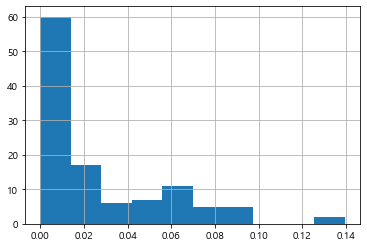

In [104]:
freq_sort['Support'].hist() # 각 상품 지지도가 0.02 미만에서 높음

### 연관규칙 생성

In [107]:
freq_items = apriori(df, min_support=0.01, use_colnames=True)
freq_items

,support,itemsets
0,0.054760,(가공유)
1,0.020641,(건면)
2,0.015080,(건어물)
3,0.015566,(견과류)
4,0.062482,(계란류)
...,...,...
151,0.012967,"(잎채소, 탄산음료)"
152,0.012045,"(잎채소, 포장반찬)"
153,0.011608,"(잎채소, 햄/소시지)"
154,0.010369,"(잎채소, 열매채소, 두부/콩나물류)"


In [108]:
rules = association_rules(freq_items, metric='confidence', min_threshold=0.2) # 최소지지도 논문 참고
print('규칙 개수:', len(rules))

규칙 개수: 68


### 규칙 확인

In [109]:
rules_plus = rules[rules['lift']>1]
rules_plus.sort_values(by='confidence', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
48,(즉석음료류),(아이스크림),0.019014,0.056629,0.012385,0.651341,11.501811,0.011308,2.705711
66,"(버섯류, 열매채소)",(잎채소),0.016561,0.078849,0.010272,0.620235,7.866111,0.008966,2.425579
63,"(열매채소, 두부/콩나물류)",(잎채소),0.018893,0.078849,0.010369,0.548843,6.960691,0.008879,2.041754
33,(버섯류),(잎채소),0.049150,0.078849,0.024089,0.490119,6.215917,0.020214,1.806599
62,"(잎채소, 두부/콩나물류)",(열매채소),0.022244,0.057552,0.010369,0.466157,8.099727,0.009089,1.765403
...,...,...,...,...,...,...,...,...,...
45,(양채류),(수입과일),0.061195,0.066829,0.012676,0.207143,3.099616,0.008586,1.176973
46,(탄산음료),(스낵류),0.125935,0.139412,0.025595,0.203239,1.457830,0.008038,1.080108
11,(냉동간편식),(잎채소),0.057139,0.078849,0.011583,0.202720,2.570991,0.007078,1.155367
35,(봉지라면),(탄산음료),0.074162,0.125935,0.014983,0.202030,1.604242,0.005643,1.095361


In [110]:
rules_minus = rules[rules['lift']<1]
rules_minus.sort_values(by='confidence', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


__A 집합일 때 B 집합이 유의미하게 발생합니다.__
- {즉석음료류} > {아이스크림}
- {버섯류, 열매채소} > {잎채소}
- {열매채소, 두부/콩나물류} > {잎채소}

\+ 최소지지도가 참고 논문보다 낮아서 좀 더 사례를 찾아봐야할 것 같음

### b) 소분류

In [111]:
# 소분류
df_pdnm = df_food[['rct_no', 'pd_nm', 'buy_ct']]
df_pdnm = df_pdnm.groupby(['rct_no', 'pd_nm'])['buy_ct'].sum()
df_pdnm = df_pdnm.unstack()

df_pdnm = df_pdnm.applymap(encode_units)
print(df_pdnm.shape)
df_pdnm.head()

(41180, 618)


pd_nm,가공계란,가공메추리알,가공우유,가공조미료,가자미,가지,간장,간편과일,갈치,감,...,홍합,화이트와인,황기,황태/북어류,황태채,회덮밥,후추,훈제/구이오징어,훈제/로스트,흑미
rct_no,,,,,,,,,,,,,,,,,,,,,
A02000091219,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A02000284827,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A02000397555,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A02000410829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A02000417751,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [112]:
freq_pdnm = df_pdnm.sum(axis=0).to_frame('Frequency')

freq_sort_pdnm = freq_pdnm.sort_values('Frequency', ascending=False)
freq_sort_pdnm = freq_sort_pdnm[freq_sort_pdnm['Frequency'] >1]

freq_sort_pdnm['Support'] = freq_sort_pdnm['Frequency'] / len(df_pdnm)
freq_sort_pdnm

,Frequency,Support
pd_nm,,
일반스낵,2728,0.066246
일반우유,2635,0.063987
생수,2533,0.061510
국물용기라면,2497,0.060636
콜라,2437,0.059179
...,...,...
버섯선물세트,2,0.000049
도미,2,0.000049
해삼,2,0.000049


<AxesSubplot:>

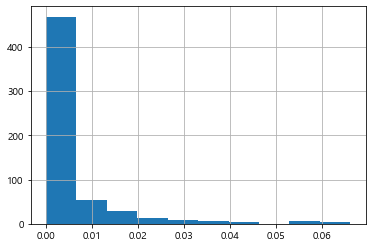

In [113]:
freq_sort_pdnm['Support'].hist() #지지도가 0.001 미만에 분포 #0.001로 하면 안 돌아갑니다...

### 연관규칙 생성

In [114]:
freq_items_pdnm = apriori(df_pdnm, min_support=0.005, use_colnames=True)
freq_items_pdnm

,support,itemsets
0,0.017047,(가공계란)
1,0.054760,(가공우유)
2,0.006241,(간장)
3,0.008839,(간편과일)
4,0.005852,(감자)
...,...,...
202,0.005270,"(콜라, 일반스낵)"
203,0.007819,"(일반스낵, 쿠키)"
204,0.005464,"(크래커, 일반스낵)"
205,0.005440,"(일반우유, 일반시리얼)"


In [115]:
rules_pdnm = association_rules(freq_items_pdnm, metric='confidence', min_threshold=0.2)
print('규칙 개수:', len(rules_pdnm))

규칙 개수: 20


### 규칙 확인

In [116]:
# 양의 관계가 있는 규칙
rules_pdnm[rules_pdnm['lift']>1].sort_values(by='confidence', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
15,(파우치/즉석음료),(얼음),0.019014,0.026056,0.012263,0.644955,24.752339,0.011768,2.743158
16,(얼음),(파우치/즉석음료),0.026056,0.019014,0.012263,0.470643,24.752339,0.011768,1.853165
12,(애호박),(두부류),0.013866,0.046187,0.005828,0.420315,9.100201,0.005188,1.645399
13,(콩나물),(두부류),0.014959,0.046187,0.005318,0.355519,7.697315,0.004627,1.479971
6,(비빔봉지라면),(국물봉지라면),0.032030,0.053497,0.011365,0.354814,6.632433,0.009651,1.467024
19,(일반시리얼),(일반우유),0.016003,0.063987,0.005440,0.339909,5.312125,0.004416,1.418005
11,(일반소주),(국산맥주),0.053473,0.059155,0.017533,0.327884,5.542797,0.014370,1.399825
14,(팽이버섯류),(두부류),0.016999,0.046187,0.005148,0.302857,6.557128,0.004363,1.368174
10,(국산맥주),(일반소주),0.059155,0.053473,0.017533,0.296388,5.542797,0.014370,1.345240
17,(옥수수스낵),(일반스낵),0.043201,0.066246,0.012627,0.292299,4.412344,0.009766,1.319419


- 음료에 파우치가 파우치에 담긴 커피/음료 같아요
- 애호박 → 두부류 = 찌개요리
- 결과가 너무 당연해서 지지도가 많이 낮아도 되는 걸 알았습니다 ㅎ

## 02. 기타 속성 포함

### a) 중분류

### b. 소분류

## 3. 간편식만 아이템으로 포함

In [76]:
hmr = ['건면', '봉지라면', '레토르트', '용기라면', '시리얼', '분말조리식', '파스타류', '비빔봉지라면', '국물봉지라면', '즉석밥'
       , '국물용기라면', '즉석카레짜장', '국수', '비빔용기라면', '즉석덮밥류' '즉석컵밥' '즉석국/찌개', '일반시리얼', '즉석스프'
       , '즉석죽', '즉석누룽지', '기타레토르트', '분말카레짜장', '냉면', '즉석면류', '건우동', '기능성시리얼', '기타건면', '냉장간편식'
       , '포장반찬', '기타냉장간편식', '김밥재료세트', '절임반찬', '냉장치킨족발류', '볶음반찬', '냉장간편떡볶이', '김치류', '냉장국탕류'
       , '조림반찬', '무침반찬', '젓갈', '냉장밥/죽', '냉장안주', '냉동간편식', '냉동만두', '기타냉동간편식', '냉동튀김', '냉동밥'
       , '냉동간편식세트', '냉동피자', '냉동떡볶이', '냉동국탕류', '냉동부침', '냉장조리', '즉석반찬', '온장조리', '초밥류', '삼각김밥'
       , '기타냉장조리', '즉석국탕', '순대', '기타온장조리', '훈제/로스트', '김밥', '샌드위치', '샐러드', '튀김류', '즉석젓갈류'
       , '즉석김치류', '피자', '도시락', '치킨류', '롤', '온장조리원부재료', '꼬치류', '즉석반찬원부재료', '족발', '냉장조리원부재료'
       , '햄버거', '즉석어묵', '농산물병통조림', '수산물통조림', '축산물통조림', '병통조림선물세트', '채소병통조림', '과일병통조림'
       , '참치통조림', '기타축산통조림', '통조림혼합세트', '햄통조림세트', '기타수산통조림', '햄통조림', '참치통조림세트', '닭고기통조림'
       , '골뱅이통조림', '꽁치고등어통조림']

In [77]:
df_hmr_mcls = DF.loc[DF['clac_mcls_nm'].apply(lambda x: x in hmr)] # 중분류 데이터
df_hmr_pdnm = DF.loc[DF['pd_nm'].apply(lambda x: x in hmr)] # 소분류 데이터

## 01. 중분류

(15439, 16)


<AxesSubplot:>

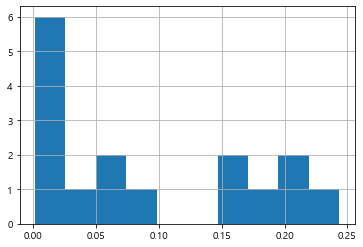

In [79]:
# 중분류 데이터 그룹화
df_mcls = df_hmr_mcls[['rct_no', 'clac_mcls_nm', 'buy_ct']]
df_mcls = df_mcls.groupby(['rct_no', 'clac_mcls_nm'])['buy_ct'].sum()
df_mcls = df_mcls.unstack()

df_mcls = df_mcls.applymap(encode_units)
print(df_mcls.shape)

# 지지도 계산
freq_mcls = df_mcls.sum(axis=0).to_frame('Frequency')

freq_sort_mcls = freq_mcls.sort_values('Frequency', ascending=False)
freq_sort_mcls = freq_sort_mcls[freq_sort_mcls['Frequency'] >1]

freq_sort_mcls['Support'] = freq_sort_mcls['Frequency'] / len(df_mcls)

# 지지도 분포 확인
freq_sort_mcls['Support'].hist()

### 연관규칙 생성

In [86]:
freq_items_mcls = apriori(df_mcls, min_support=0.001, use_colnames=True)
freq_items_mcls

,support,itemsets
0,0.055055,(건면)
1,0.152406,(냉동간편식)
2,0.178833,(냉장간편식)
3,0.243539,(냉장조리)
4,0.017229,(농산물병통조림)
...,...,...
158,0.001166,"(포장반찬, 봉지라면, 냉동간편식, 용기라면)"
159,0.001166,"(봉지라면, 냉장간편식, 용기라면, 레토르트)"
160,0.002267,"(포장반찬, 냉장간편식, 봉지라면, 레토르트)"
161,0.001555,"(포장반찬, 냉장간편식, 용기라면, 레토르트)"


In [118]:
rules_mcls = association_rules(freq_items_mcls, metric='confidence', min_threshold=0.2)
print('규칙 개수:', len(rules_mcls))

규칙 개수: 157


### 규칙 확인

In [120]:
# 양의 관계가 있는 규칙
rules_mcls_sort = rules_mcls[rules_mcls['lift']>1].sort_values(by='confidence', ascending=False)
rules_mcls_sort

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
153,"(포장반찬, 용기라면, 봉지라면)",(레토르트),0.002720,0.157523,0.001619,0.595238,3.778734,0.001191,2.081413
140,"(포장반찬, 냉동간편식, 용기라면)",(봉지라면),0.002073,0.197811,0.001166,0.562500,2.843627,0.000756,1.833575
113,"(축산물통조림, 용기라면)",(봉지라면),0.002008,0.197811,0.001101,0.548387,2.772282,0.000704,1.776276
94,"(농산물병통조림, 포장반찬)",(레토르트),0.002008,0.157523,0.001101,0.548387,3.481311,0.000785,1.865484
149,"(포장반찬, 냉장간편식, 용기라면)",(레토르트),0.002850,0.157523,0.001555,0.545455,3.462694,0.001106,1.853449
...,...,...,...,...,...,...,...,...,...
57,"(포장반찬, 레토르트)",(냉동간편식),0.020986,0.152406,0.004275,0.203704,1.336584,0.001077,1.064420
9,(농산물병통조림),(봉지라면),0.017229,0.197811,0.003498,0.203008,1.026271,0.000090,1.006520
37,"(냉동간편식, 봉지라면)",(냉장간편식),0.032904,0.178833,0.006671,0.202756,1.133773,0.000787,1.030007
114,"(포장반찬, 용기라면)",(봉지라면),0.013472,0.197811,0.002720,0.201923,1.020789,0.000055,1.005153


In [121]:
# 봉지라면이 조건구에 있는 규칙
rules_mcls_sort[rules_mcls_sort['antecedents'].apply(lambda x: '봉지라면' in x)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
153,"(포장반찬, 용기라면, 봉지라면)",(레토르트),0.002720,0.157523,0.001619,0.595238,3.778734,0.001191,2.081413
145,"(포장반찬, 냉장간편식, 봉지라면)",(레토르트),0.004858,0.157523,0.002267,0.466667,2.962527,0.001502,1.579644
139,"(포장반찬, 용기라면, 봉지라면)",(냉동간편식),0.002720,0.152406,0.001166,0.428571,2.812033,0.000751,1.483289
134,"(포장반찬, 냉동간편식, 봉지라면)",(레토르트),0.005311,0.157523,0.002267,0.426829,2.709629,0.001430,1.469853
148,"(냉장간편식, 봉지라면, 레토르트)",(포장반찬),0.005959,0.093011,0.002267,0.380435,4.090204,0.001713,1.463912
142,"(용기라면, 냉장간편식, 봉지라면)",(레토르트),0.003109,0.157523,0.001166,0.375000,2.380602,0.000676,1.347963
124,"(용기라면, 냉장간편식, 봉지라면)",(냉동간편식),0.003109,0.152406,0.001166,0.375000,2.460529,0.000692,1.356150
103,"(포장반찬, 봉지라면)",(레토르트),0.020014,0.157523,0.007319,0.365696,2.321537,0.004166,1.328191
128,"(포장반찬, 냉장간편식, 봉지라면)",(냉동간편식),0.004858,0.152406,0.001749,0.360000,2.362108,0.001008,1.324365
118,"(냉장간편식, 봉지라면, 레토르트)",(냉동간편식),0.005959,0.152406,0.002137,0.358696,2.353550,0.001229,1.321672


In [122]:
# 봉지라면이 결론구에 있는 규칙
rules_mcls_sort[rules_mcls_sort['consequents'].apply(lambda x: '봉지라면' in x)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
140,"(포장반찬, 냉동간편식, 용기라면)",(봉지라면),0.002073,0.197811,0.001166,0.562500,2.843627,0.000756,1.833575
113,"(축산물통조림, 용기라면)",(봉지라면),0.002008,0.197811,0.001101,0.548387,2.772282,0.000704,1.776276
135,"(포장반찬, 냉동간편식, 레토르트)",(봉지라면),0.004275,0.197811,0.002267,0.530303,2.680861,0.001421,1.707887
111,"(축산물통조림, 수산물통조림)",(봉지라면),0.002332,0.197811,0.001166,0.500000,2.527669,0.000705,1.604379
81,"(냉장간편식, 축산물통조림)",(봉지라면),0.002397,0.197811,0.001166,0.486486,2.459353,0.000692,1.562158
127,"(포장반찬, 냉장간편식, 냉동간편식)",(봉지라면),0.003627,0.197811,0.001749,0.482143,2.437395,0.001031,1.549055
133,"(냉동간편식, 용기라면, 레토르트)",(봉지라면),0.003821,0.197811,0.001814,0.474576,2.399143,0.001058,1.526747
31,"(건면, 용기라면)",(봉지라면),0.003239,0.197811,0.001490,0.460000,2.325455,0.000849,1.485536
58,"(수산물통조림, 냉동간편식)",(봉지라면),0.005246,0.197811,0.002397,0.456790,2.309228,0.001359,1.476758
63,"(축산물통조림, 냉동간편식)",(봉지라면),0.004145,0.197811,0.001814,0.437500,2.211710,0.000994,1.426114


\+ 지지도가 너무 높은 아이템 빼고 해보기

- 보고 싶은 아이템이 있으면 확인해보기

## 02. 소분류

(14097, 77)


,Frequency,Support
pd_nm,,
국물용기라면,2497,0.177130
국물봉지라면,2203,0.156274
비빔봉지라면,1319,0.093566
삼각김밥,1067,0.075690
비빔용기라면,964,0.068383
...,...,...
건우동,6,0.000426
족발,5,0.000355
햄통조림세트,5,0.000355


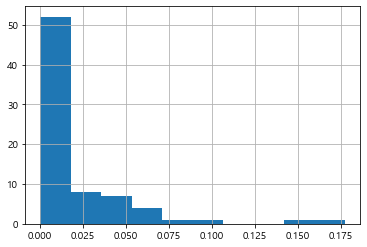

In [123]:
# 소분류 데이터 그룹화
df_pdnm = df_hmr_pdnm[['rct_no', 'pd_nm', 'buy_ct']]
df_pdnm = df_pdnm.groupby(['rct_no', 'pd_nm'])['buy_ct'].sum()
df_pdnm = df_pdnm.unstack()

df_pdnm = df_pdnm.applymap(encode_units)
print(df_pdnm.shape)

# 지지도 계산
freq_pdnm = df_pdnm.sum(axis=0).to_frame('Frequency')

freq_sort_pdnm = freq_pdnm.sort_values('Frequency', ascending=False)
freq_sort_pdnm = freq_sort_pdnm[freq_sort_pdnm['Frequency'] >1]

freq_sort_pdnm['Support'] = freq_sort_pdnm['Frequency'] / len(df_pdnm)

# 지지도 분포 확인
freq_sort_pdnm['Support'].hist()
freq_sort_pdnm

### 연관규칙 생성

In [124]:
freq_items_pdnm = apriori(df_pdnm, min_support=0.001, use_colnames=True)
freq_items_pdnm

,support,itemsets
0,0.002554,(골뱅이통조림)
1,0.003902,(과일병통조림)
2,0.156274,(국물봉지라면)
3,0.177130,(국물용기라면)
4,0.013336,(국수)
...,...,...
278,0.001277,"(김치류, 즉석밥, 비빔용기라면)"
279,0.002270,"(냉동튀김, 냉동만두, 비빔봉지라면)"
280,0.001135,"(즉석밥, 냉동튀김, 비빔봉지라면)"
281,0.001064,"(김치류, 즉석밥, 국물봉지라면, 비빔봉지라면)"


### 규칙 확인

In [125]:
rules_pdnm = association_rules(freq_items_pdnm, metric='confidence', min_threshold=0.2)
print('규칙 개수:', len(rules_pdnm))

규칙 개수: 97


In [128]:
# 양의 관계가 있는 규칙
rules_pdnm_sort = rules_pdnm[rules_pdnm['lift']>1].sort_values(by='confidence', ascending=False)
rules_pdnm_sort

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
87,"(김치류, 즉석밥, 비빔봉지라면)",(국물봉지라면),0.001632,0.156274,0.001064,0.652174,4.173262,0.000809,2.425711
55,"(햄통조림, 비빔봉지라면)",(국물봉지라면),0.002057,0.156274,0.001277,0.620690,3.971794,0.000955,2.224368
19,"(비빔봉지라면, 국수)",(국물봉지라면),0.001773,0.156274,0.001064,0.600000,3.839401,0.000787,2.109314
92,"(냉동튀김, 냉동만두, 비빔봉지라면)",(국물봉지라면),0.002270,0.156274,0.001348,0.593750,3.799407,0.000993,2.076863
27,"(기타냉장간편식, 비빔봉지라면)",(국물봉지라면),0.002625,0.156274,0.001490,0.567568,3.631866,0.001080,1.951115
...,...,...,...,...,...,...,...,...,...
0,(국수),(국물봉지라면),0.013336,0.156274,0.002767,0.207447,1.327452,0.000682,1.064567
11,(김치류),(즉석밥),0.050862,0.066823,0.010499,0.206416,3.089003,0.007100,1.175902
9,(삼각김밥),(국물용기라면),0.075690,0.177130,0.015535,0.205248,1.158745,0.002128,1.035380
95,"(냉동튀김, 냉동만두)","(국물봉지라면, 비빔봉지라면)",0.006597,0.033199,0.001348,0.204301,6.153915,0.001129,1.215034


- 국물봉지라면 지지도 자체가 높은 것 같네용

In [131]:
# 국물봉지라면이 조건구에 있는 규칙
rules_pdnm_sort[rules_pdnm_sort['antecedents'].apply(lambda x: '국물봉지라면' in x)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
88,"(김치류, 국물봉지라면, 비빔봉지라면)",(즉석밥),0.001986,0.066823,0.001064,0.535714,8.016947,0.000931,2.009920
91,"(냉동튀김, 냉동만두, 국물봉지라면)",(비빔봉지라면),0.002696,0.093566,0.001348,0.500000,5.343821,0.001096,1.812868
44,"(냉동튀김, 국물봉지라면)",(비빔봉지라면),0.009009,0.093566,0.003618,0.401575,4.291888,0.002775,1.514699
48,"(일반시리얼, 국물봉지라면)",(비빔봉지라면),0.006810,0.093566,0.002696,0.395833,4.230525,0.002058,1.500305
33,"(김치류, 국물봉지라면)",(즉석밥),0.008796,0.066823,0.003476,0.395161,5.913576,0.002888,1.542853
17,"(비빔용기라면, 국물봉지라면)",(국물용기라면),0.006384,0.177130,0.002483,0.388889,2.195501,0.001352,1.346515
18,"(국물봉지라면, 국수)",(비빔봉지라면),0.002767,0.093566,0.001064,0.384615,4.110632,0.000805,1.472955
22,"(국물봉지라면, 기타냉동간편식)",(냉동튀김),0.004327,0.045471,0.001632,0.377049,8.292141,0.001435,1.532271
93,"(냉동튀김, 국물봉지라면, 비빔봉지라면)",(냉동만두),0.003618,0.055757,0.001348,0.372549,6.681709,0.001146,1.504888
54,"(햄통조림, 국물봉지라면)",(비빔봉지라면),0.003476,0.093566,0.001277,0.367347,3.926073,0.000952,1.432751


In [132]:
# 국물봉지라면이 결론구에 있는 규칙
rules_pdnm_sort[rules_pdnm_sort['consequents'].apply(lambda x: '국물봉지라면' in x)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
87,"(김치류, 즉석밥, 비빔봉지라면)",(국물봉지라면),0.001632,0.156274,0.001064,0.652174,4.173262,0.000809,2.425711
55,"(햄통조림, 비빔봉지라면)",(국물봉지라면),0.002057,0.156274,0.001277,0.620690,3.971794,0.000955,2.224368
19,"(비빔봉지라면, 국수)",(국물봉지라면),0.001773,0.156274,0.001064,0.600000,3.839401,0.000787,2.109314
92,"(냉동튀김, 냉동만두, 비빔봉지라면)",(국물봉지라면),0.002270,0.156274,0.001348,0.593750,3.799407,0.000993,2.076863
27,"(기타냉장간편식, 비빔봉지라면)",(국물봉지라면),0.002625,0.156274,0.001490,0.567568,3.631866,0.001080,1.951115
45,"(냉동튀김, 비빔봉지라면)",(국물봉지라면),0.006455,0.156274,0.003618,0.560440,3.586254,0.002609,1.919476
49,"(일반시리얼, 비빔봉지라면)",(국물봉지라면),0.004895,0.156274,0.002696,0.550725,3.524088,0.001931,1.877970
39,"(즉석밥, 냉동만두)",(국물봉지라면),0.003121,0.156274,0.001702,0.545455,3.490364,0.001215,1.856196
38,"(냉동만두, 비빔봉지라면)",(국물봉지라면),0.008583,0.156274,0.004611,0.537190,3.437480,0.003270,1.823050
51,"(즉석밥, 비빔봉지라면)",(국물봉지라면),0.007023,0.156274,0.003689,0.525253,3.361092,0.002591,1.777209


In [135]:
# 국물봉지라면이 결론구에 있는 규칙 제외
ex_ramen = rules_pdnm_sort[rules_pdnm_sort['consequents'].apply(lambda x: '국물봉지라면' not in x)]
ex_ramen

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
88,"(김치류, 국물봉지라면, 비빔봉지라면)",(즉석밥),0.001986,0.066823,0.001064,0.535714,8.016947,0.000931,2.009920
66,"(김밥, 치킨류)",(국물용기라면),0.002128,0.177130,0.001135,0.533333,3.010973,0.000758,1.763293
91,"(냉동튀김, 냉동만두, 국물봉지라면)",(비빔봉지라면),0.002696,0.093566,0.001348,0.500000,5.343821,0.001096,1.812868
75,"(즉석밥, 비빔용기라면)",(국물용기라면),0.003334,0.177130,0.001632,0.489362,2.762728,0.001041,1.611454
76,"(김치류, 기타냉장간편식)",(즉석밥),0.004114,0.066823,0.001986,0.482759,7.224467,0.001711,1.804143
...,...,...,...,...,...,...,...,...,...
12,(햄버거),(샌드위치),0.019721,0.046038,0.004185,0.212230,4.609876,0.003277,1.210965
46,"(비빔용기라면, 국물봉지라면)",(비빔봉지라면),0.006384,0.093566,0.001348,0.211111,2.256280,0.000750,1.149001
11,(김치류),(즉석밥),0.050862,0.066823,0.010499,0.206416,3.089003,0.007100,1.175902
9,(삼각김밥),(국물용기라면),0.075690,0.177130,0.015535,0.205248,1.158745,0.002128,1.035380


In [136]:
# 결론구에 즉석밥이 있는 규칙
ex_ramen[ex_ramen['consequents'].apply(lambda x: '즉석밥' in x)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
88,"(김치류, 국물봉지라면, 비빔봉지라면)",(즉석밥),0.001986,0.066823,0.001064,0.535714,8.016947,0.000931,2.009920
76,"(김치류, 기타냉장간편식)",(즉석밥),0.004114,0.066823,0.001986,0.482759,7.224467,0.001711,1.804143
80,"(김치류, 비빔용기라면)",(즉석밥),0.003050,0.066823,0.001277,0.418605,6.264405,0.001073,1.605065
33,"(김치류, 국물봉지라면)",(즉석밥),0.008796,0.066823,0.003476,0.395161,5.913576,0.002888,1.542853
78,"(김치류, 비빔봉지라면)",(즉석밥),0.004398,0.066823,0.001632,0.370968,5.551520,0.001338,1.483513
59,"(국물용기라면, 기타냉장간편식)",(즉석밥),0.003476,0.066823,0.001277,0.367347,5.497335,0.001045,1.475022
69,"(김치류, 국물용기라면)",(즉석밥),0.008512,0.066823,0.002767,0.325000,4.863615,0.002198,1.382485
29,"(기타냉장간편식, 국물봉지라면)",(즉석밥),0.004824,0.066823,0.001419,0.294118,4.401461,0.001096,1.322001
11,(김치류),(즉석밥),0.050862,0.066823,0.010499,0.206416,3.089003,0.007100,1.175902


In [137]:
rules_pdnm_sort[rules_pdnm_sort['antecedents'].apply(lambda x: len(x) > 2)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
87,"(김치류, 즉석밥, 비빔봉지라면)",(국물봉지라면),0.001632,0.156274,0.001064,0.652174,4.173262,0.000809,2.425711
92,"(냉동튀김, 냉동만두, 비빔봉지라면)",(국물봉지라면),0.002270,0.156274,0.001348,0.593750,3.799407,0.000993,2.076863
88,"(김치류, 국물봉지라면, 비빔봉지라면)",(즉석밥),0.001986,0.066823,0.001064,0.535714,8.016947,0.000931,2.009920
91,"(냉동튀김, 냉동만두, 국물봉지라면)",(비빔봉지라면),0.002696,0.093566,0.001348,0.500000,5.343821,0.001096,1.812868
93,"(냉동튀김, 국물봉지라면, 비빔봉지라면)",(냉동만두),0.003618,0.055757,0.001348,0.372549,6.681709,0.001146,1.504888
86,"(김치류, 즉석밥, 국물봉지라면)",(비빔봉지라면),0.003476,0.093566,0.001064,0.306122,3.271727,0.000739,1.306331
94,"(냉동만두, 국물봉지라면, 비빔봉지라면)",(냉동튀김),0.004611,0.045471,0.001348,0.292308,6.428489,0.001138,1.348791
89,"(즉석밥, 국물봉지라면, 비빔봉지라면)",(김치류),0.003689,0.050862,0.001064,0.288462,5.671468,0.000876,1.333924


- 상품이 더 세분화되어있으면 좋을 것 같은데 ㅜㅜ

# 연령: 30대